# Проект 2. Разведывательный анализ данных. Итоговое задание

## Описание проекта

Вас пригласили поучаствовать в одном из проектов UNICEF — международного подразделения ООН, чья миссия состоит в повышении уровня благополучия детей по всему миру. 

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

## Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
from scipy.stats import norm
import warnings

warnings.filterwarnings("ignore")

study = pd.read_csv('stud_math.csv')

## Задача проекта и подход к анализу

Задача данного проекта - проанализировать корреляцию показателя 'score' (т.е. результатов экзамена по математике) с другими показателями в датафрейме.

В наборе данных присутствуют незаполненные ячейки - при анализе мы их опустим. К тому же, необходимо проверить количественные и качественные показатели на соответствие здравому смыслу и диапазону возможных показаний (например, в столбце 'age' должны быть только показатели от 15 до 22 включительно и т.п.) 

In [3]:
print(*study.keys(), sep='\n')

school
sex
age
address
famsize
Pstatus
Medu
Fedu
Mjob
Fjob
reason
guardian
traveltime
studytime
failures
schoolsup
famsup
paid
activities
nursery
studytime, granular
higher
internet
romantic
famrel
freetime
goout
health
absences
score


In [4]:
study.describe()

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
count,395.000000,392.000000,371.000000,367.000000,388.000000,373.000000,388.000000,368.000000,384.000000,387.000000,380.000000,383.000000,389.000000
mean,16.696203,2.750000,2.614555,1.438692,2.038660,0.337802,-6.115979,3.937500,3.231771,3.105943,3.531579,7.279373,52.262211
std,1.276043,1.098127,2.228732,0.694181,0.842078,0.743135,2.526235,0.927277,0.993940,1.115896,1.396019,23.465197,22.919022
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-12.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,-6.000000,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,-6.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,-3.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,40.000000,4.000000,4.000000,3.000000,-3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


## Предобработка данных

Показатель 'score' включает в себя 389 значений, однако есть показатели с бо́льшим количеством значений.

In [5]:
pd.DataFrame(study.score.sort_values(ascending=False))

,score
47,100.0
374,95.0
110,95.0
286,95.0
8,95.0
...,...
244,NaN
270,NaN
283,NaN
312,NaN


Опускаем из набора данных строки, где значения показателя 'score' == NaN

In [41]:
study = study.dropna(subset=['score'])

Проверяем, показатели какого типа приведены в этом наборе данных.

In [40]:
study.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

13 количественных показателей и 17 номинативных.

Убедимся, что все показатели занесены правильно.
(Допустимые значения приведены в комментариях)

In [7]:
study = study.loc[study.age.between(15, 22, inclusive=True)]
# возраст ученика (от 15 до 22)

study = study.loc[study.Medu.between(0, 4, inclusive=True)]
# образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

study = study.loc[study.Fedu.between(0, 4, inclusive=True)]
# образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

study = study.loc[study.traveltime.between(1, 4, inclusive=True)]
# время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

study = study.loc[study.studytime.between(1, 4, inclusive=True)]
# время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

study = study.loc[study.failures.between(0, 3, inclusive=True)]
# количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

study = study.loc[study.famrel.between(1, 5, inclusive=True)]
# семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

study = study.loc[study.freetime.between(1, 5, inclusive=True)]
# свободное время после школы (от 1 - очень мало до 5 - очень мого)

study = study.loc[study.goout.between(1, 5, inclusive=True)]
# проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

study = study.loc[study.health.between(1, 5, inclusive=True)]
# текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

Проверим, как изменилось максимальное количество строк в базе данных.

In [8]:
print(len(study))

270


270 строк против 395 в необработанной базе данных. Т.е., ~31% строк содержит ошибочно занесённую информацию.

## Анализ количественных показателей

Исследуем интересующий нас показатель - 'score'.

count    270.000000
mean      52.277778
std       22.183266
min        0.000000
25%       41.250000
50%       55.000000
75%       68.750000
max      100.000000
Name: score, dtype: float64

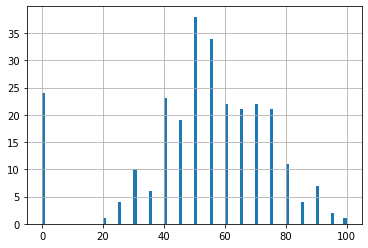

In [9]:
study.score.hist(bins=int(study.score.max()-study.score.min()))
study.score.describe()

Мы видим, что показатель 'score' условно можно разделить на 2 кластера: нулевые значения и положительные значения.

In [10]:
study['score_cluster'] = study.score.apply(
    lambda x: 'zero' if x == 0 else 'positive')
display(study.head())

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,health,absences,score,score_cluster
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,...,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0,positive
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,...,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0,positive
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,...,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0,positive
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,...,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0,positive
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,...,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0,positive


Рассмотрим, какие количественные показатели указаны в наборе данных (без учёта 'score').

In [43]:
study_quant_list = [*study.select_dtypes(['float64', 'int64']).columns]
print(*study_quant_list[:-1], sep='\n')
print()
print(f"Всего {len(study_quant_list[:-1])} показателей.")

age
Medu
Fedu
traveltime
studytime
failures
studytime, granular
famrel
freetime
goout
health
absences

Всего 12 показателей.


Проверим корреляцию показателя score с другими количественными показателями.
Но перед этим убедимся, что наши данные не содержат большого количества выбросов.

In [12]:
def outliers_check(column):
    perc75 = study[column].quantile(0.75)
    perc25 = study[column].quantile(0.25)
    IQR = perc75-perc25
    if len(study.loc[(study[column] < (perc25-1.5*IQR)) | (study[column] > (perc75+1.5*IQR))]) > 0:
        print(f"Выбросы в параметре {column}")

In [13]:
for column in study_quant_list:
    outliers_check(column)

Выбросы в параметре age
Выбросы в параметре traveltime
Выбросы в параметре studytime
Выбросы в параметре failures
Выбросы в параметре studytime, granular
Выбросы в параметре famrel
Выбросы в параметре freetime
Выбросы в параметре absences


Выбросы в 8 из 12 количественных показателей.

Однако практически все выбросы лежат в рамках допустимых значений, поскольку мы уже делали предобработку данных и включили только данные, лежащие в допустимом диапазоне.
Исключение составляют лишь такие показатели, как 'studytime, granular' и 'absences'.

Устраним выбросы по этим двум показателям.

In [14]:
for column in ['studytime, granular', 'absences']:
    perc75 = study[column].quantile(0.75)
    perc25 = study[column].quantile(0.25)
    IQR = perc75-perc25
    study = study.loc[(study[column] >= (perc25-1.5*IQR)) &
                      (study[column] <= (perc75+1.5*IQR))]

In [15]:
study.describe()

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
count,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000
mean,16.744589,2.796537,2.584416,1.463203,1.865801,0.324675,-5.597403,3.948052,3.285714,3.108225,3.497835,4.519481,51.645022
std,1.264792,1.102245,1.083681,0.696067,0.681558,0.753685,2.044673,0.892911,0.949011,1.084063,1.385874,4.899717,21.581483
min,15.000000,0.000000,1.000000,1.000000,1.000000,0.000000,-9.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,-6.000000,4.000000,3.000000,2.000000,3.000000,0.000000,45.000000
50%,17.000000,3.000000,3.000000,1.000000,2.000000,0.000000,-6.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,4.000000,2.000000,2.000000,0.000000,-3.000000,5.000000,4.000000,4.000000,5.000000,6.500000,65.000000
max,22.000000,4.000000,4.000000,4.000000,3.000000,3.000000,-3.000000,5.000000,5.000000,5.000000,5.000000,20.000000,95.000000


Теперь можно проверить корреляцию между 'score' и другими количественными показателями.
Значения NaN исключим из рассмотрения, изменив значение параметра 'drop' на 'False'.

In [16]:
display(pd.DataFrame(study.corrwith(study['score'], drop=True)[:-1]))

,0
age,-0.158956
Medu,0.174058
Fedu,0.101861
traveltime,-0.023449
studytime,0.049066
failures,-0.340375
"studytime, granular",-0.049066
famrel,-0.004571
freetime,0.085217
goout,-0.138659


Как мы видим, корреляция с другими количественными показателями крайне слабая.

Попробуем проанализировать количественные показатели относительно положительных результатов 'score'.

In [17]:
display(pd.DataFrame(study.loc[study['score_cluster'] == 'positive'].corrwith(
    study['score'], drop=True)[:-1]))

,0
age,-0.149725
Medu,0.151228
Fedu,0.108541
traveltime,-0.082212
studytime,0.074369
failures,-0.273777
"studytime, granular",-0.074369
famrel,0.035610
freetime,0.020319
goout,-0.198184


Глобально никаких изменений.

Представим количественные показатели в виде боксплотов, отдельно при 'score' равном нулю и отдельно для положительного 'score'.

In [18]:
study_pos = study.loc[study['score_cluster'] == 'positive']

In [19]:
study_pos.describe()

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,16.709524,2.833333,2.600000,1.471429,1.866667,0.266667,-5.600000,3.938095,3.314286,3.100000,3.495238,4.971429,56.809524
std,1.255192,1.100602,1.081378,0.706527,0.678680,0.688479,2.036039,0.897085,0.966563,1.060153,1.391181,4.915471,14.756781
min,15.000000,0.000000,1.000000,1.000000,1.000000,0.000000,-9.000000,1.000000,1.000000,1.000000,1.000000,0.000000,25.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,-6.000000,4.000000,3.000000,2.000000,3.000000,2.000000,50.000000
50%,17.000000,3.000000,3.000000,1.000000,2.000000,0.000000,-6.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,4.000000,2.000000,2.000000,0.000000,-3.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,4.000000,4.000000,3.000000,3.000000,-3.000000,5.000000,5.000000,5.000000,5.000000,20.000000,95.000000


Выбросы не показываем.

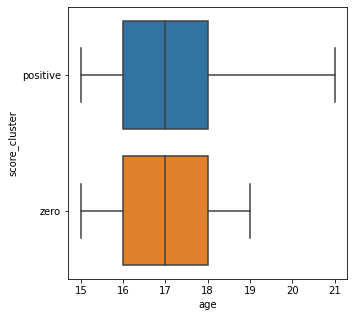

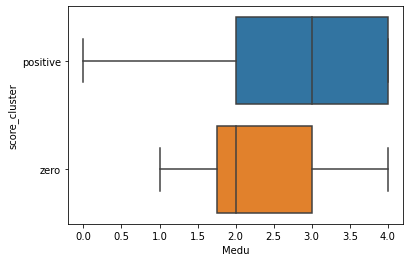

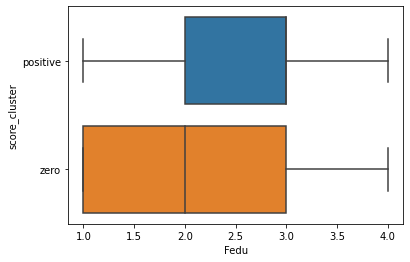

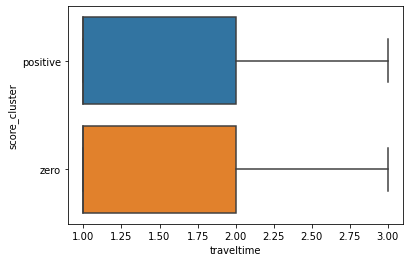

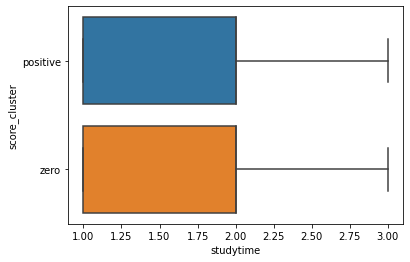

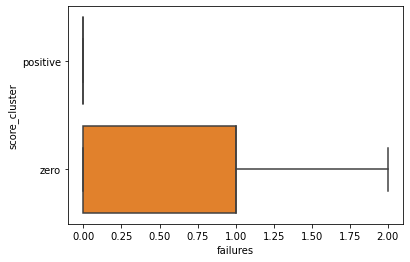

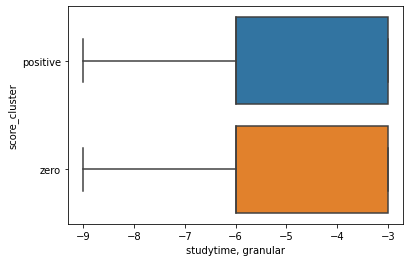

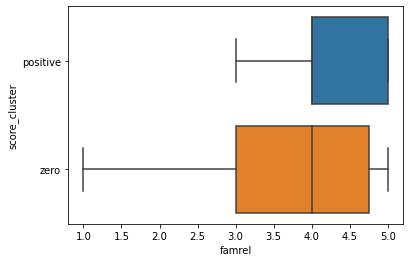

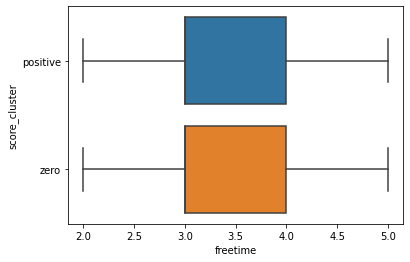

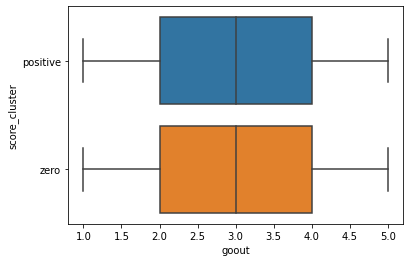

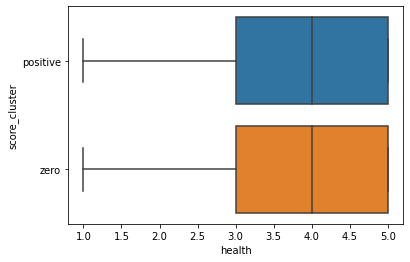

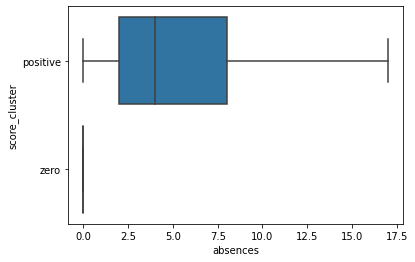

In [39]:
fig = plt.subplots(figsize=(5, 5))

for column in study_quant_list:
    if column != 'score':
        sns.boxplot(x=study[column],
                    y=study['score_cluster'], data=study, orient="h", showfliers=False)
        plt.show()

Показатели 'age', 'traveltime', 'studytime', 'studytime, granular', 'freetime', 'goout', 'health' имеют одинаковый нижний и верхний квартили, одну и ту же медиану, один и тот же интерквартильный размах.

Исключим их из модели.

Таким образом, остаётся только 6 из 13 количественных показателей.

## Анализ номинативных показателей

Перевызовем исходную базу данных, уберём NaN-значения для показателя 'score' и создадим столбец 'score_cluster'.

In [31]:
study = pd.read_csv('stud_math.csv')

study.dropna(subset=['score'])

study['score_cluster'] = study.score.apply(
    lambda x: 'zero' if x == 0 else 'positive')

display(study.head())

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,health,absences,score,score_cluster
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,...,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0,positive
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,...,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0,positive
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,...,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0,positive
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,...,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0,positive
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,...,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0,positive


In [32]:
study_nom = study.select_dtypes('object')
study_nom_list = [*study_nom.columns]
study_nom['score'] = study['score']
study_nom['score_cluster'] = study['score_cluster']

Выведем боксплоты только для тех показателей, где медиана показателя 'score' отличается между разными значениями.

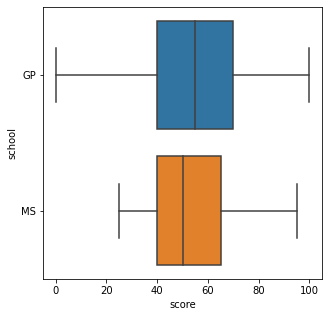

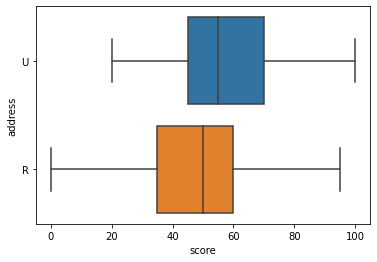

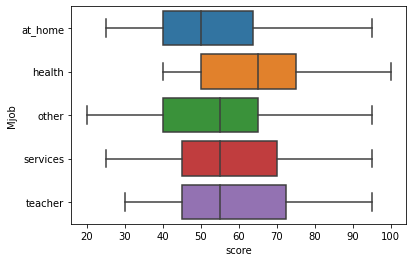

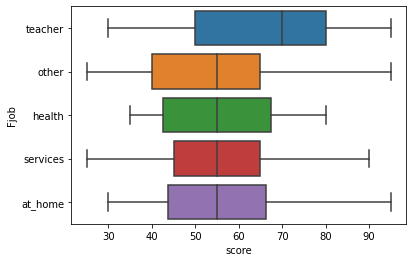

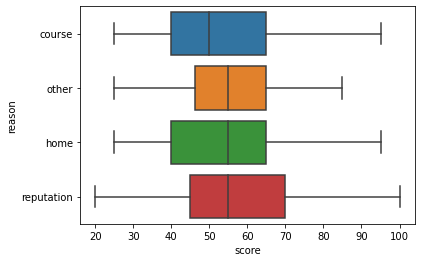

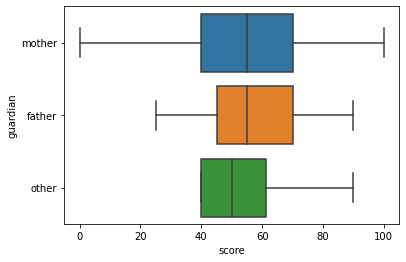

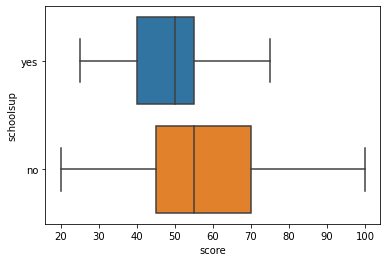

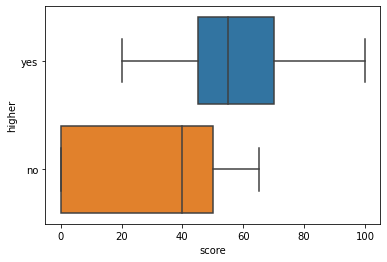

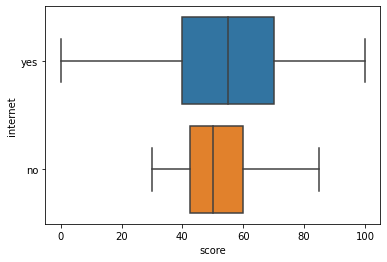

In [33]:
fig, ax = plt.subplots(figsize=(5, 5))
column_list = []

for column in study_nom_list:
    if column != 'score_cluster':
        study_nom_working = study_nom.dropna(subset=[column])
        i = 0
        for x in range(1, study_nom_working[column].nunique()):
            x_median = study_nom_working.loc[study_nom_working[column] == study_nom_working[column].unique()[
                x]]['score'].median()
            x_prev_median = study_nom_working.loc[study_nom_working[column] == study_nom_working[column].unique()[
                x-1]]['score'].median()
            if x_median != x_prev_median and i == 0:
                sns.boxplot(data=study_nom_working,
                            x=study_nom_working['score'], y=study_nom_working[column], showfliers=False)
                plt.show()
                column_list.append(column)
                i += 1

Есть предположение, что пропорция учеников с нулевой отметкой за экзамен остаётся приблизительно одинаковой вне зависимости от параметра и значения.
Проверим. Альтернативная гипотеза - пропорции неравны.
Доверительный интервал 95%.

Статистически значимое изменение пропорции положительных результатов в параметре "schoolsup". Доверительный интервал: 0.95


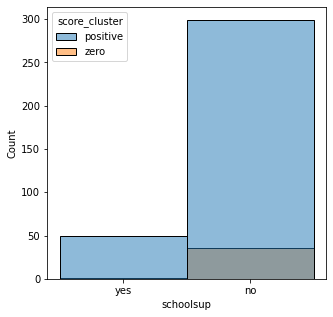

Статистически значимое изменение пропорции положительных результатов в параметре "paid". Доверительный интервал: 0.95


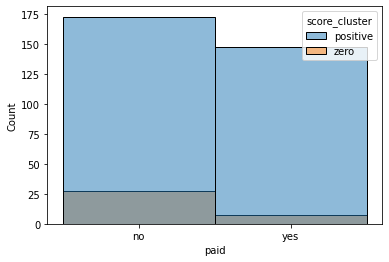

Статистически значимое изменение пропорции положительных результатов в параметре "higher". Доверительный интервал: 0.95


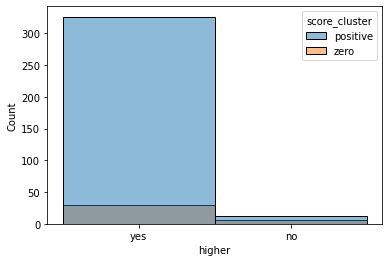

Статистически значимое изменение пропорции положительных результатов в параметре "romantic". Доверительный интервал: 0.95


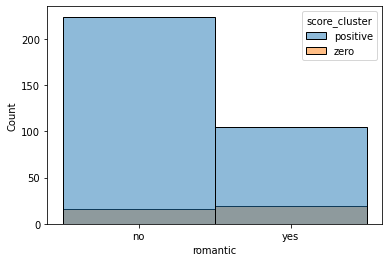

In [34]:
true_pos_prop = study['score_cluster'].value_counts()[0]
true_n = len(study['score_cluster'])
confidence_level = 0.95
fig, ax = plt.subplots(figsize=(5, 5))

for column in study_nom_list:
    if column != 'score_cluster':
        study_nom_working = study_nom.dropna(subset=[column])
        for x in range(0, study_nom_working[column].nunique()):
            new_pos_prop = len(study_nom_working.loc[(study_nom_working[column] == study_nom_working[column].unique()[
                x]) & (study_nom_working['score_cluster'] == 'positive')])
            new_n = len(study_nom_working.loc[(study_nom_working[column] == study_nom_working[column].unique()[
                x])])
            average_pos_prop = (
                true_pos_prop + new_pos_prop) / (true_n + new_n)
            z_stat = ((new_pos_prop / new_n) - (true_pos_prop / true_n)) / \
                (np.sqrt(average_pos_prop*(1-average_pos_prop))
                 * np.sqrt(1/true_n + 1/new_n))
            if z_stat < 0:
                p_value = 1 - norm.cdf(z_stat)
            else:
                p_value = norm.cdf(z_stat)
            result = (p_value > confidence_level)
            if result == True:
                print(
                    f'Статистически значимое изменение пропорции положительных результатов в параметре "{column}". Доверительный интервал: {confidence_level}')
                sns.histplot(data=study_nom_working,
                             x=study_nom_working[column], hue='score_cluster')
                plt.show()
                column_list.append(column)

Оставим выведенные показатели в модели, потому что они связаны с нулевой оценкой за экзамен.

Выведем список номинативных показателей, которые могут представлять для нас интерес.

In [35]:
print(*set(column_list), sep=', ')
print()
print(f"{len(set(column_list))} показателей.")

romantic, address, reason, Mjob, internet, higher, paid, schoolsup, guardian, Fjob, school

11 показателей.


Из 17 в начальном наборе данных.

## Выводы

- Очень много данных с ошибками занесения информации / NaN-значениями (~31 % всех строк для количественных показателей)
- Слабая корреляция количественных показателей с показателем 'score' не позволяет использовать их для точного предсказания оценки за экзамен. Однако, если упростить условие задачи и пытаться предсказывать только то, положительную или нулевую оценку получит студент, то можно оставить исключить 7 из 13 количественных показателей ('age', 'traveltime', 'studytime', 'studytime, granular', 'freetime', 'goout', 'health').
- Говоря о номинативных показателях, мы оставляем 11 показателей из 17 в начальном наборе данных. Они позволяют как помочь в определении нулевого / положительного результата экзамена, так и в предсказании итоговой оценки.